In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import pandas as pd
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    if x > 180:
        x -= 360
    return land.contains(sgeom.Point(x, y))

In [2]:
nc = xr.open_dataset(f'/climca/data/CESM2-ETH/b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.1300.linear-weak/TREFHT_ann_b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.1300.linear-weak.nc')
lats, lons = nc.lat.values, nc.lon.values
locations = []
for y in range(50,56,10):
    iy = np.argmin(np.abs(lats - y))
    for x in range(0,360,10):
        if is_land(x,y):
            ix = np.argmin(np.abs(lons - x))
            locations.append(dict(lat=lats[iy], lon=lons[ix], iy=iy, ix=ix))
locations = pd.DataFrame(locations)
locations.head()

,lat,lon,iy,ix
0,50.418848,10.0,149,8
1,50.418848,20.0,149,16
2,50.418848,30.0,149,24
3,50.418848,40.0,149,32
4,50.418848,50.0,149,40


In [3]:
locations.to_csv('locations.csv')

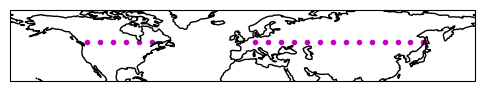

In [4]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), subplot_kw={'projection': cartopy.crs.PlateCarree(central_longitude=0)})
ax.coastlines()
ax.set_extent([-180,180,20,75])
ax.scatter(locations['lon'].values, locations['lat'].values, transform=cartopy.crs.PlateCarree(), color='m', marker='.')
plt.savefig('locations.png', bbox_inches='tight')

In [5]:
dummy = []
for y in range(50,56,10):
    iy = np.argmin(np.abs(lats - y))
    for x in range(0,360,10):
        if is_land(x,y):
            ix = np.argmin(np.abs(lons - x))
            for run in ['1300','1400','1500']:
                dummy.append(dict(lat=lats[iy], lon=lons[ix], run=run))
dummy = pd.DataFrame(dummy)
dummy['reproduced trend'] = np.nan
dummy['dynamic trend'] = np.nan
dummy['thermodynamic trend'] = np.nan
dummy['other trend 1'] = np.nan
dummy['other trend 2'] = np.nan
dummy.to_csv('TREFHT_JJA_seasmean.csv')
dummy.head()

,lat,lon,run,reproduced trend,dynamic trend,thermodynamic trend,other trend 1,other trend 2
0,50.418848,10.0,1300,NaN,NaN,NaN,NaN,NaN
1,50.418848,10.0,1400,NaN,NaN,NaN,NaN,NaN
2,50.418848,10.0,1500,NaN,NaN,NaN,NaN,NaN
3,50.418848,20.0,1300,NaN,NaN,NaN,NaN,NaN
4,50.418848,20.0,1400,NaN,NaN,NaN,NaN,NaN


In [10]:
nc = xr.open_dataset(f'/climca/data/CESM2-ETH/b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.1300.linear-weak/TREFHT_day_b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.1300.linear-weak.nc')
dummy_array = xr.DataArray(
    dims=['lat','lon','run','v','time'],
    coords=dict(
        lat=np.unique(locations.lat.values),
        lon=np.unique(locations.lon.values),
        run=['1300','1400','1500'],
        time=nc.time[nc.time.dt.month.isin([6,7,8])]
    )
)
out = xr.Dataset({
    'predict self' : dummy_array,
    'predict piCOntrol nudged' : dummy_array,
})
out

<xarray.Dataset>
Dimensions:                   (lat: 1, lon: 20, run: 3, time: 23092, v: 1)
Coordinates:
  * lat                       (lat) float64 50.42
  * lon                       (lon) float64 10.0 20.0 30.0 ... 270.0 280.0 290.0
  * run                       (run) <U4 '1300' '1400' '1500'
  * time                      (time) object 1850-06-01 00:00:00 ... 2100-08-3...
Dimensions without coordinates: v
Data variables:
    predict self              (lat, lon, run, v, time) float64 nan nan ... nan
    predict piCOntrol nudged  (lat, lon, run, v, time) float64 nan nan ... nan

In [11]:
out.to_netcdf('TREFHT_JJA_daily.nc')